In [1]:
import os
import shap
import sys
sys.path.append('./pyuid3')
#sys.path.append('./EXPLAN/LORE')
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer
import random



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3
from sklearn.svm import SVC

import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [3]:
def generate_phantom_data(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [4]:
def decision_boundary(clf1, explain_instance, X,y,f1='x1',f2='x2', dec_only=True, ax=None, palette='Set2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])

    if type(Z) is list:
        Z=np.array(Z)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    if ax is None:
        fig,ax= plt.subplots(figsize=(9,4))

    
    ax.contour(xx, yy, Z, cmap=palette)
    if not dec_only:
        X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap=palette,ax=ax)

    
    ax.plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)

    ax.set(title='DecTree decision boundary')
 

In [5]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired


def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Example of local concept building (inverse sampling, density sampling prevents from building overcomplicated trees)
Local is not local at all -- the concept may be local, but its building could require a reach-out away from the locality,
On the outher hand, locality should not be considered in a global setting, becasue the simplicity migh be lost (dt covering unrelated concepts as additional branches) 
The selection of the samples to build local concepts to explain is crucial

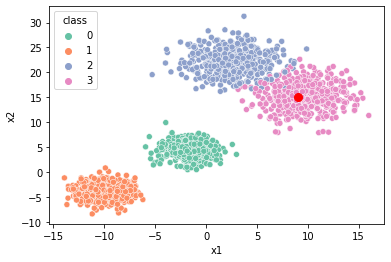

In [6]:
instance2explain = {'x1':9,'x2':15, 'class':3}
#instance2explain = {'x1':4,'x2':20, 'class':0}
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=1,cluster_std=1.4)
X2,y2 = sklearn.datasets.make_blobs(n_samples=1000, centers=2, random_state=42,cluster_std=2.4)
X2[:,0]+=5
X2[:,1]+=13
X=np.concatenate((X,X2))
y= np.concatenate((y,y2+2))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')
graph.axes.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

### LORE neigh

In [7]:
Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

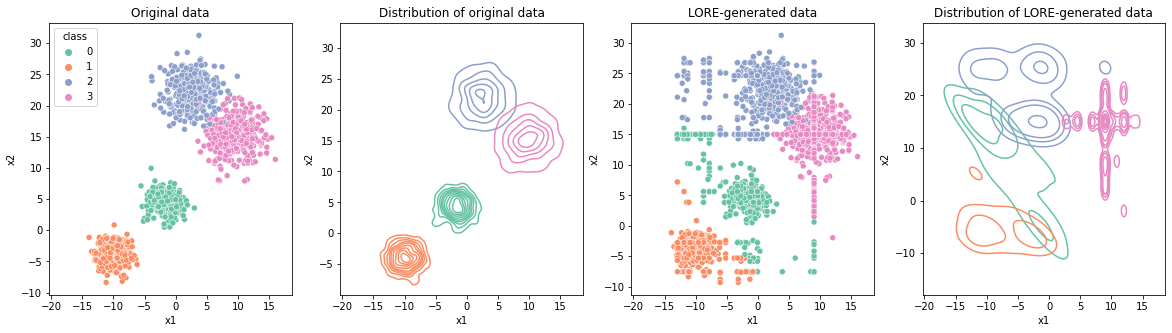

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('LORE-generated data')
axes[3].set_title('Distribution of LORE-generated data')
plt.savefig('./pix/lore-generated-data.pdf', format='pdf',bbox_inches='tight')

In [9]:
X_explain = np.concatenate((np.array(list(instance2explain.values()))[:-1].reshape(1,-1), dataset['X']))
exp_LORE, info_LORE = lore.explain(0, X_explain,
                                   dataset, blackbox,
                                   ng_function=genetic_neighborhood,
                                   discrete_use_probabilities=True,
                                   continuous_function_estimation=False,
                                   returns_infos=True, path='./EXPLAN/yadt/',
                                   sep=';', log=True, depth=10)

rule_LORE = {} 
for i,v in  exp_LORE[0][1].items():
    rule_LORE[i] = [v]


./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1052\n + load time: 0.007047 secs (3.51 MiB/s, 149.28 K rows/s)\n + indexing ... done\n + total time: 0.008743 secs (2.83 MiB/s, 120.32 K rows/s)\nBuilding 1 tree(s) on 1052 cases\n + tree(s) built\n + size: 29 depth: 7 nf: 2 time: 0.012119 secs\nPruning tree using training set\n + tree pruned\n + size: 21 depth: 6 nf: 2 time: 0.000332 secs\n'


In [10]:
exp_LORE

([{'class': 3},
  {'x1': '>1.906168', 'x2': '-0.321586< x2 <=20.28666'},
  [528.0, 2.6]],
 [{'x2': '<=-0.321586'}])

### EXPLAN neigh

In [11]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

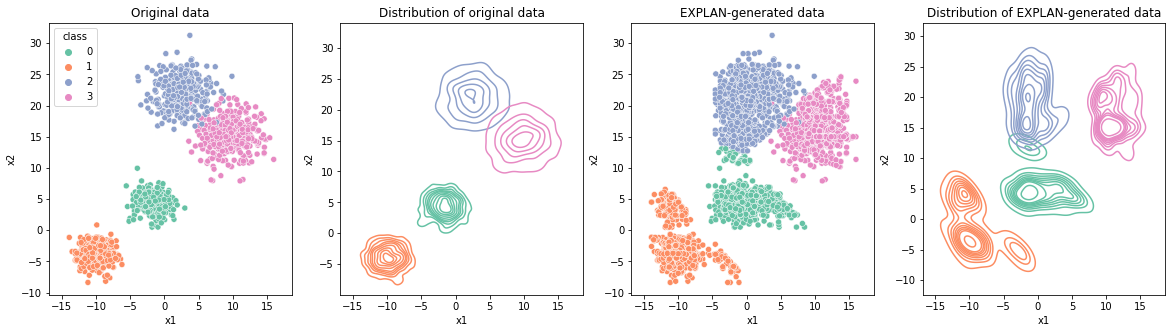

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=True,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[3],legend=False)
axes[0].set_title('Original data')
axes[1].set_title('Distribution of original data')
axes[2].set_title('EXPLAN-generated data')
axes[3].set_title('Distribution of EXPLAN-generated data')
plt.savefig('./pix/explan-generated-data.pdf', format='pdf',bbox_inches='tight')

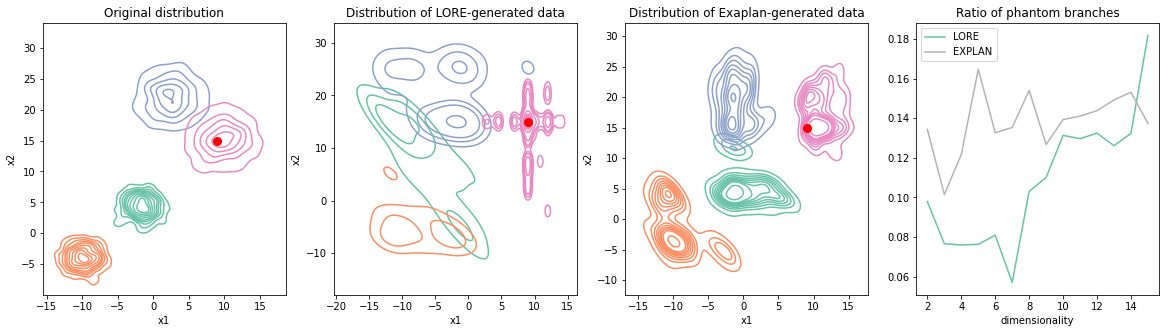

In [13]:
sdf = pd.read_csv('phantoms.csv')
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
#sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.kdeplot(data=Ndf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan']].mean().plot(ax=axes[3], cmap='Set2')

axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original distribution')
axes[1].set_title('Distribution of LORE-generated data')
axes[2].set_title('Distribution of Exaplan-generated data')
axes[3].set_title('Ratio of phantom branches')
axes[3].legend(['LORE','EXPLAN'])
plt.savefig('./pix/phantom-generated-data.pdf', format='pdf',bbox_inches='tight')

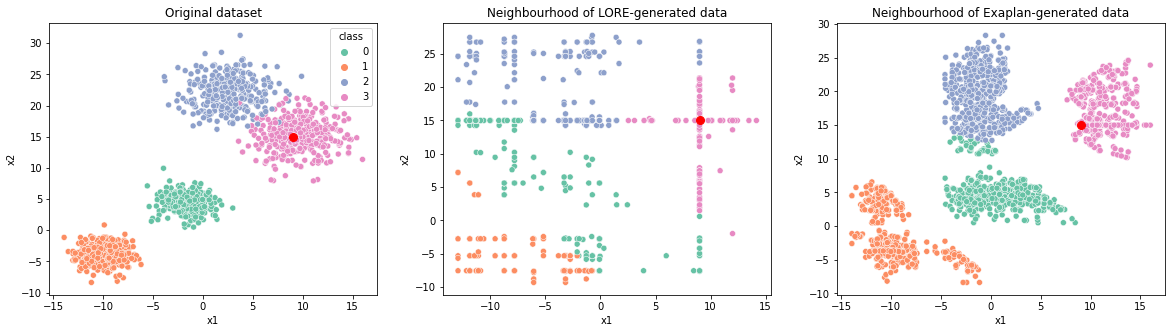

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5),sharex=False,sharey=False)
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[0])
#sns.kdeplot(data=train,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[0],legend=False)
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2', ax=axes[2], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
#sns.kdeplot(data=Zdf,x='x1',y='x2',hue='class', kind='kde', fill=False, palette='Set2',ax=axes[1],legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)

axes[0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0].set_title('Original dataset')
axes[1].set_title('Neighbourhood of LORE-generated data')
axes[2].set_title('Neighbourhood of Exaplan-generated data')
plt.savefig('./pix/neighbourhood-generated-data.pdf', format='pdf',bbox_inches='tight')

In [15]:
exp_EXPLAN, info_EXPLAN = explan.Explainer(np.array(list(instance2explain.values()))[:-1],
                                               blackbox,
                                               dataset,
                                               N_samples=3000,
                                               tau=200,depth=10)
rule_EXPLAN = {} 
for i,v in  exp_EXPLAN[1].items():
    rule_EXPLAN[i] = [v]

exp_EXPLAN

./EXPLAN/yadt/dTcmd -fd ./EXPLAN/yadt/dataset.data -fm ./EXPLAN/yadt/dataset.names -sep ; -d ./EXPLAN/yadt/dataset.dot -depth 10
b'YaDT version 2.2.0 (c) S. Ruggieri 2002-2019\nReading text data\n + atts: 2 class: 1 weight: 0 rows: 1596\n + load time: 0.006116 secs (9.6 MiB/s, 260.95 K rows/s)\n + indexing ... done\n + total time: 0.011179 secs (5.25 MiB/s, 142.76 K rows/s)\nBuilding 1 tree(s) on 1596 cases\n + tree(s) built\n + size: 23 depth: 5 nf: 2 time: 0.004993 secs\nPruning tree using training set\n + tree pruned\n + size: 23 depth: 5 nf: 2 time: 0.000199 secs\n'


[{'class': 3}, {'x2': '>6.944029', 'x1': '>6.677442'}, [381.0, 1.3]]

### LUX neigh

In [16]:
new_cluster = train[train[target]==1]
new_cluster.loc[:,'x1'] += 15
new_cluster.loc[:,'x2'] -=  5
new_cluster.loc[:,target] = 0

train_nc = pd.concat((new_cluster,train),ignore_index=True)

In [17]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_base_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=False, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='local',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_inverse_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='local',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_density_local, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=False,parity_strategy='local',
                                         representative='centroid')
#nearest optics based concept, measure distance, exclude everyhing larger than this threshold


lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_base, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=False, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='global',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_inverse, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=False, radius_sampling=False, 
                                         oversampling=False,parity_strategy='global',
                                         representative='centroid')

lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=10,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=50)
X_train_sample_density, _ = lux.create_sample_bb(train_nc[features], blackbox.predict(train_nc[features]),[train_nc.iloc[len(train_nc)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=False,parity_strategy='global',
                                         representative='centroid')
#nearest optics based concept, measure distance, exclude everyhing larger than this threshold



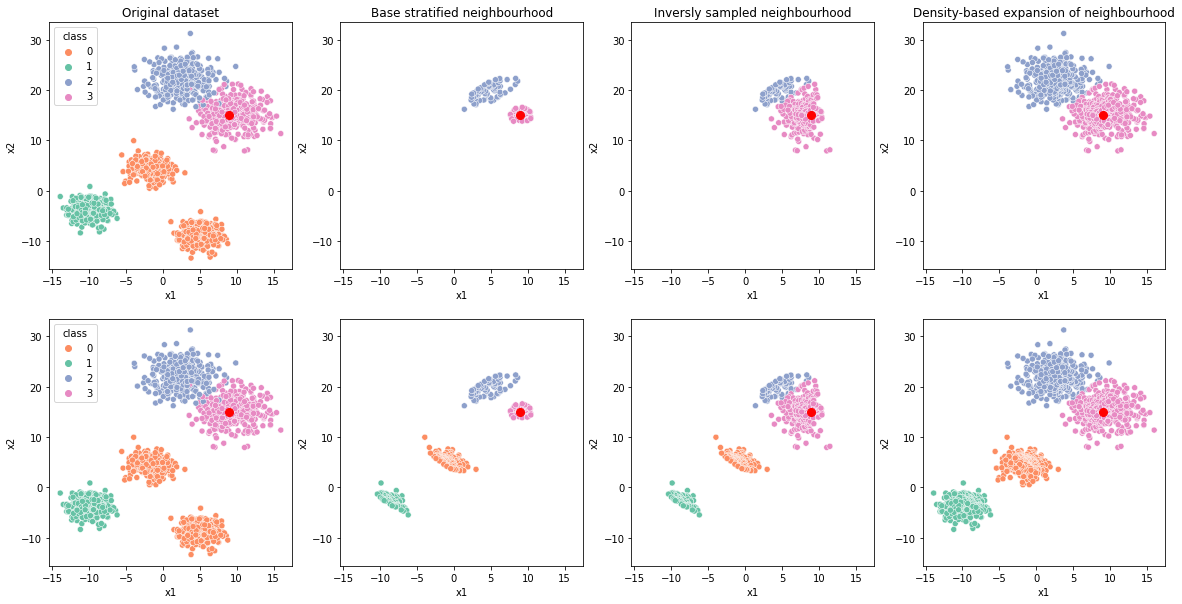

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10),sharex=False,sharey=False)
palette = dict(zip(train['class'].unique(),sns.color_palette('Set2',train['class'].nunique())))
graph = sns.scatterplot(data=train_nc,x='x1', y='x2', hue='class',palette=palette, ax=axes[0][0])
Zdf_lux = pd.DataFrame(X_train_sample_base_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][1], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_inverse_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][2], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_density_local, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[0][3], legend=False)
axes[0][0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[0][3].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())


graph = sns.scatterplot(data=train_nc,x='x1', y='x2', hue='class',palette=palette, ax=axes[1][0])
Zdf_lux = pd.DataFrame(X_train_sample_base, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][1], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_inverse, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][2], legend=False)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

Zdf_lux = pd.DataFrame(X_train_sample_density, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class',palette=palette,ax=axes[1][3], legend=False)
axes[1][0].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][1].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][2].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
axes[1][3].plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)

graph_lux.set_ylim(graph.get_ylim())
graph_lux.set_xlim(graph.get_xlim())

axes[0][0].set_title('Original dataset')
axes[0][1].set_title('Base stratified neighbourhood')
axes[0][2].set_title('Inversly sampled neighbourhood')
axes[0][3].set_title('Density-based expansion of neighbourhood')
plt.savefig('./pix/neighbourhood-lux-data.pdf', format='pdf',bbox_inches='tight')

## Counterfactual generation

In [19]:
def noproba_predictor(x, clf):
    preds = clf.predict_proba(x)
    hot = np.argmax(preds,axis=1)
    result = np.zeros(preds.shape)
    for i in range(0,len(result)):
        result[i,hot[i]] = 1
    return result

In [70]:
instance2explain['x2']=17

In [86]:
luxpure = LUX(predict_proba = lambda x : noproba_predictor(x,clf=blackbox),  neighborhood_size=0.3,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=20)
luxpure.fit(train_nc[features], train_nc[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, oblique=False,
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=True,prune=True,parity_strategy='global',
                                         representative='centroid')


In [87]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
luxpure.justify(ei)[0]

'IF x1 >= 2.0570127983183744 AND x2 < 18.369499634571362 THEN class = 3 # 0.9519230769230769\n'

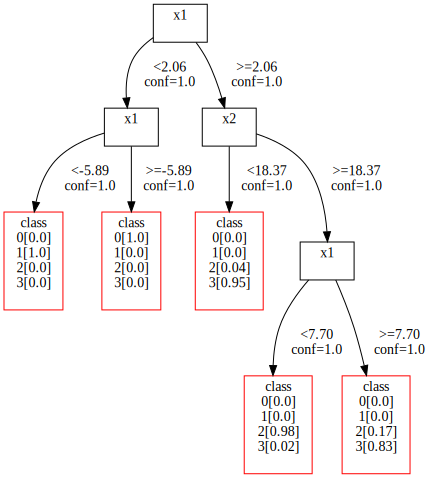

In [72]:
#prind the uncertain local tree for the given instance
import graphviz
luxpure.uid3.tree.save_dot('./pix/F2_tree-pure.dot',fmt='.2f')
graphviz.Source.from_file('./pix/F2_tree-pure.dot')

In [73]:
lux = LUX(predict_proba = lambda x : noproba_predictor(x,clf=blackbox),classifier=blackbox,  neighborhood_size=0.3,max_depth=3,  node_size_limit = 4, grow_confidence_threshold = 0 , min_samples=20)
lux.fit(train_nc[features], train_nc[target],(list(instance2explain.values())[:-1]),X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, oblique=True,
                                         inverse_sampling=True, class_names=[0,1,2,3],density_sampling=True, radius_sampling=False, 
                                         oversampling=True,prune=True,parity_strategy='global',
                                         representative='centroid')


svm gain 0.518575767866841,  pure: 0.7069839512548568, reular gain 0.7216219392767347, pure 0.9676141942018874
svm gain 0.2656272766207317,  pure: 0.7802576553436587, reular gain 0.31625234343081304, pure 0.7802576553436587
svm gain 0.37734496017009955,  pure: 0.8806702069166772, reular gain 0.22660942266045578, pure 0.5197968498666852


In [74]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x2 < 1.0009745819200455 * x1+12.358577783503671 AND x2 >= 7.915549614517881 THEN class = 3 # 1.0\n'

In [75]:
cf = lux.counterfactual(ei, train_nc[features], counterfactual_representative='nearest', topn=1)[0]
print(f"Counterfactual for {ei} to change from class {lux.predict(ei)[0]} to class {cf['prediction']}: \n{cf['counterfactual']}")

Counterfactual for [[ 9 17]] to change from class 3 to class 2: 
x1     6.922731
x2    19.446083
Name: 1411, dtype: float64


In [88]:
cf['rule']

{'x2': ['>= 7.915549614517881',
  '>= 1.0009745819200455 * x1+12.358577783503671']}

In [76]:
arrow = cf['counterfactual'].values-ei
arrow

array([[-2.07726883,  2.44608269]])

In [77]:
cf_medoid = lux.counterfactual(ei, train_nc[features], counterfactual_representative='medoid', topn=1)[0]
print(f"Counterfactual for {ei} to change from class {lux.predict(ei)[0]} to class {cf['prediction']}: \n{cf_medoid['counterfactual']}")

Counterfactual for [[ 9 17]] to change from class 3 to class 2: 
x1     2.558766
x2    22.085701
Name: 948, dtype: float64


In [78]:
arrow_medoid = cf_medoid['counterfactual'].values-ei
arrow_medoid

array([[-6.44123352,  5.08570086]])

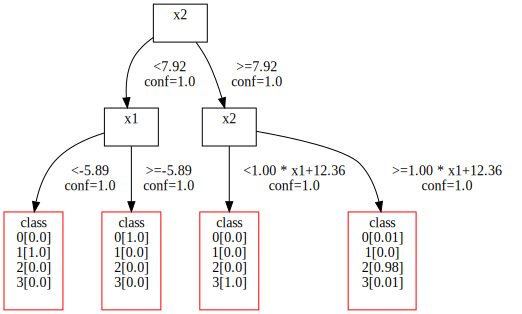

In [79]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('./pix/F2_tree-cf.dot',fmt='.2f')
graphviz.Source.from_file('./pix/F2_tree-cf.dot')

In [85]:
ei = np.array(list(instance2explain.values())[:-1]).reshape(1,-1)
lux.justify(ei)[0]

'IF x2 < 1.0009745819200455 * x1+12.358577783503671 AND x2 >= 7.915549614517881 THEN class = 3 # 1.0\n'

In [80]:
i2edf = pd.DataFrame(ei, columns = features)
cfmedoid = cf_medoid['counterfactual'].to_frame().T
cfmedoid[target]= blackbox.predict(cfmedoid)
i2edf[target]= blackbox.predict(i2edf)

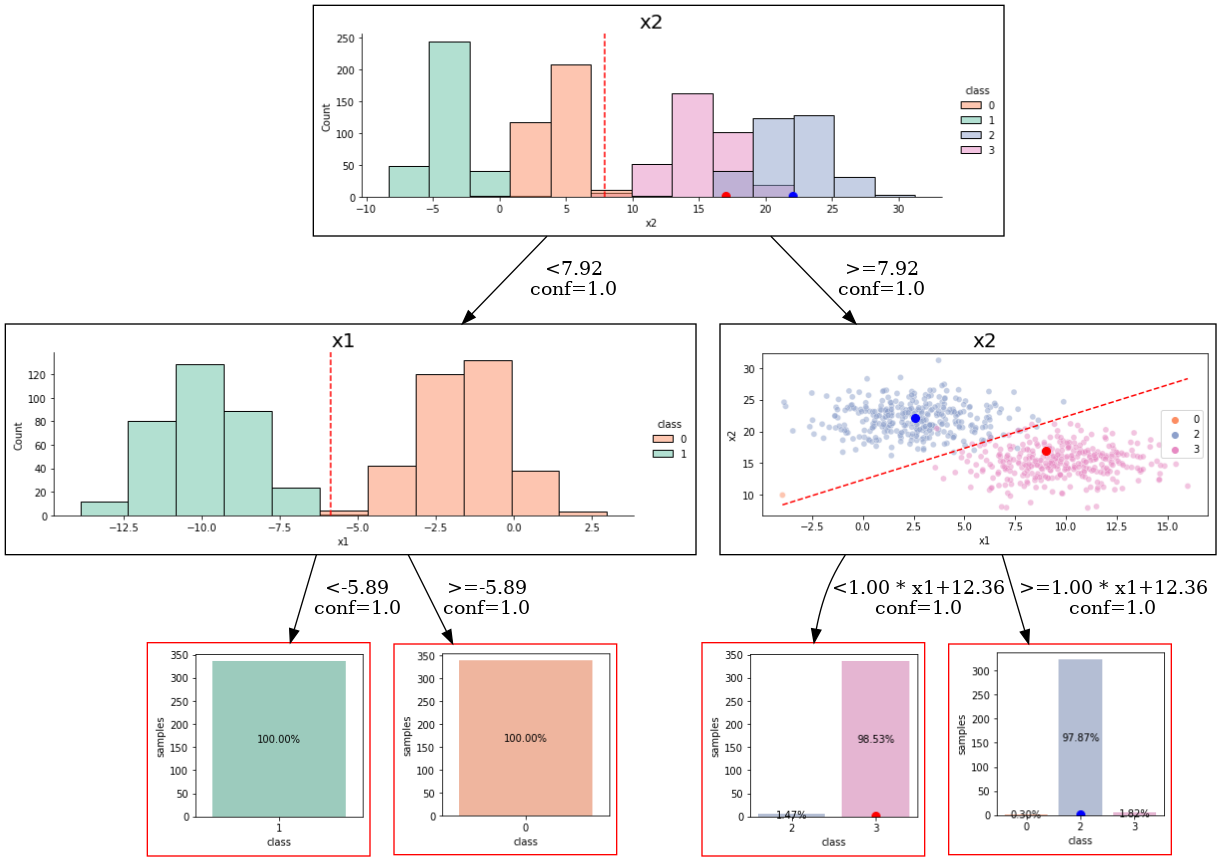

In [81]:
import graphviz
from graphviz import Source
from IPython.display import SVG, Image

#counterfactual

lux.uid3.tree.save_dot('./pix/F3_tree-cf-visual.dot',fmt='.2f',visual=True, background_data=train, instance2explain = i2edf, counterfactual=cfmedoid)
gvz=graphviz.Source.from_file('./pix/F3_tree-cf-visual.dot')
!dot -Tpng ./pix/F3_tree-cf-visual.dot > tree.png
Image('tree.png')

In [82]:
Zdf_lux['LUX predictions'] = lux.predict(Zdf_lux)
Zdf_lux['Blackbox predictions'] = blackbox.predict(Zdf_lux[features])

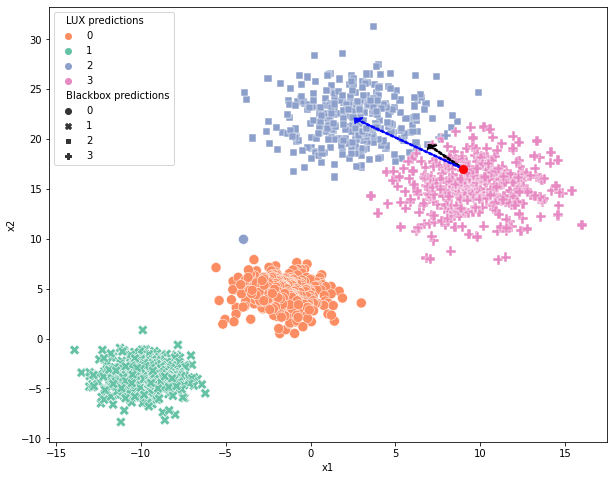

In [83]:
fig, ax = plt.subplots(figsize=(10,8))
graph_lux = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='LUX predictions',palette=palette, legend=True, style='Blackbox predictions',ax=ax)
ax.plot(instance2explain['x1'], instance2explain['x2'], 'or', markersize=8)
ax.arrow(ei.ravel()[0],ei.ravel()[1],arrow[0][0],arrow[0][1],head_width=0.8, head_length=0.4,length_includes_head=True,linestyle='--', width=0.14, color='k')
ax.arrow(ei.ravel()[0],ei.ravel()[1],arrow_medoid[0][0],arrow_medoid[0][1],head_width=0.8, head_length=0.4,length_includes_head=True,linestyle='--', width=0.14, color='blue')
graph_lux.collections[0].set_sizes([100])    
#decision_boundary(lux,train.iloc[len(train)-1], Zdf_lux[features],Zdf_lux[target],f1='x1',f2='x2', dec_only=True, ax=ax)

plt.savefig('./pix/F2_neighbourhood-lux-data.pdf', format='pdf',bbox_inches='tight')

In [84]:
sns.color_palette("Set2")[1]

(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)

In [35]:
color1 = sns.color_palette("Set2")[0]
color0 = sns.color_palette("Set2")[1]
color2 = sns.color_palette("Set2")[2]
color3 = sns.color_palette("Set2")[3]

In [49]:
"".join([f'{int(c*255):0x}' for c in color0])


'fc8d62'

In [34]:
"".join([f'{int(c*255):0x}' for c in color1])

'66c2a5'

In [35]:
"".join([f'{int(c*255):0x}' for c in color2])

'8da0cb'

In [36]:
"".join([f'{int(c*255):0x}' for c in color3])

'e78ac3'

## Example of Greedy algorithm vs SHAP-powered tree (shap-powered tree is less complicated)

In [43]:
#todo; the iris dataset the complexity as a number of features used
#does it improve the consistency with shap? it does not have to?
a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
al = np.zeros(100)
b = np.random.multivariate_normal( mean=[1, 1], cov=[[0.05, 0], [0, 0.05]], size=100) #0
bl = np.zeros(100)
c = np.random.multivariate_normal( mean=[0, 1], cov=[[0.05, 0], [0, 0.05]], size=100) #1
cl = np.ones(100)
d = np.random.multivariate_normal( mean=[1, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #1
dl = np.ones(100)
noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,400)])
labels = np.concatenate((al,bl,cl,dl))
xor = np.concatenate((a,b,c,d))


# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# al = np.zeros(300)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,400)])
# labels = np.concatenate((al,cl))
# xor = np.concatenate((a,c))

#between
# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# al = np.zeros(300)
# d = np.random.multivariate_normal( mean=[0, 3], cov=[[0.05, 0], [0, 0.05]], size=300) #0
# dl = np.zeros(300)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,700)])
# labels = np.concatenate((al,cl,dl))
# xor = np.concatenate((a,c,d))

#3classes
# a = np.random.multivariate_normal( mean=[0, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
# al = np.ones(100)*2
# b = np.random.multivariate_normal( mean=[2, 0], cov=[[0.05, 0], [0, 0.05]], size=100) #0
# bl = np.zeros(100)
# noise = np.array([np.random.choice(np.arange(0, 2), p=[0.6,0.4]) for i in range(0,300)])
# labels = np.concatenate((al,cl,bl))
# xor = np.concatenate((a,c,b))


noise_labels = np.abs(labels-noise)
xornoise = np.concatenate((xor, noise_labels.reshape(-1,1)), axis=1)
dataset = np.concatenate((xornoise, labels.reshape(-1,1)),axis=1)

d2 = False
if d2:
    dataset = np.concatenate((xor, labels.reshape(-1,1)),axis=1)



In [44]:
if d2:
    xords = pd.DataFrame(dataset, columns=['x1','x2','class'])
else:
    xords = pd.DataFrame(dataset, columns=['x1','x2','x3','class'])
    

In [45]:
xords[target] = xords[target].astype(int)

In [46]:
train, test = train_test_split(xords, random_state=42)
clf = MLPClassifier()#GradientBoostingClassifier(random_state=42)# svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

0.97

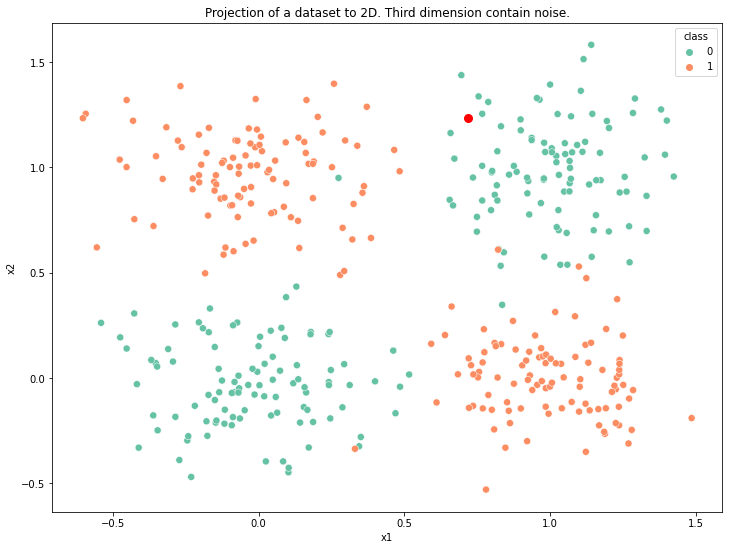

In [47]:
i2e = train.iloc[len(train)-1][features].values.reshape(1,-1)
plt.figure(figsize=(12,9))
graph=sns.scatterplot(data=xords,x='x1',y='x2',hue='class',palette='Set2')
graph.collections[0].set_sizes([50])      
features = [f for f in xords.columns if f not in ['class']]
target = 'class'
graph.axes.plot(i2e[0][0], i2e[0][1], 'or', markersize=8)
plt.title('Projection of a dataset to 2D. Third dimension contain noise.')
plt.savefig('./pix/F1_scatterplot.pdf', format='pdf',bbox_inches='tight')

In [167]:
def noproba_predictor(x):
    preds = clf.predict_proba(x)
    hot = np.argmax(preds,axis=1)
    result = np.zeros(preds.shape)
    for i in range(0,len(result)):
        result[i,hot[i]] = 1
    return result

lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*0.8),max_depth=2,  node_size_limit = 10, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,inverse_sampling=True, density_sampling=True, use_parity=True, oversampling=True)

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

['IF x2 >= 1.022283434306698 AND x3 < 1.0 THEN class = 0 # 0.7477268012672249\n']

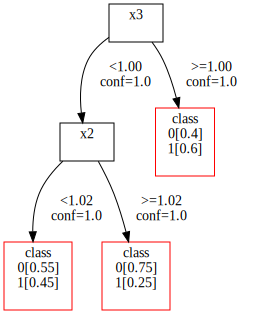

In [168]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('./pix/F1_tree-simple.dot',fmt='.2f')
graphviz.Source.from_file('./pix/F1_tree-simple.dot')

## SHAP values

In [105]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(clf.predict_proba, train[features])
explainer =shap.Explainer(clf.predict_proba, train[features])
shap_values_o = explainer(train[features])

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [106]:
shap_values=[sv for sv in np.moveaxis(shap_values_o.values, 2,0)]

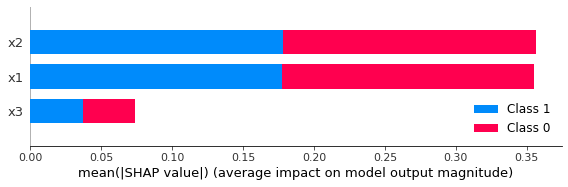

In [107]:
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

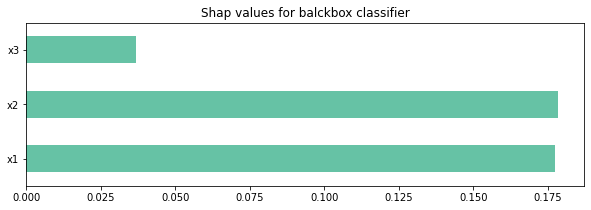

In [108]:
barshap = abs(shap_values_o.values).mean(0).mean(1)
sdf = pd.DataFrame(barshap, index=['x1','x2','x3'])
sdf.plot.barh(legend=False,cmap='Set2', figsize=(10,3))
plt.title('Shap values for balckbox classifier')
plt.savefig('./pix/F1_shap-values-blackbox.pdf', format='pdf',bbox_inches='tight')

In [171]:
lux = LUX(predict_proba = clf.predict_proba, classifier=clf,neighborhood_size=int(len(train)*0.6),max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=i2e,class_names=[0,1],n_jobs=1,oblique=True,inverse_sampling=True, use_parity=True, oversampling=False, parity_strategy='global')

#see the justification of the instance being classified for a given class
lux.justify(np.array(i2e))

svm gain 0.0007687648429815481,  pure: 0.0021682993828021635, reular gain 0.0030676143116662316, pure 0.008670279349666021
svm gain 0.003863168005749597,  pure: 0.011420627644728731, reular gain 0.004842165781018166, pure 0.015231104060277056
svm gain 0.07856943920525547,  pure: 0.3524949722881542, reular gain 0.14263817504610637, pure 0.3524949722881542


['IF x1 < 1.2877502456396197 AND x3 < 0.5 THEN class = 0 # 0.6048997813332376\n']

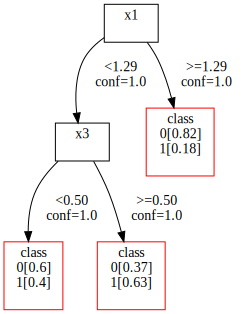

In [172]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('./pix/F1_tree-shapobliq.dot',fmt='.2f')
graphviz.Source.from_file('./pix/F1_tree-shapobliq.dot')

## Example of uncertainty incorporation in LUX (explaning why model made predictio when model is uncertain of its decision)

## Example of data generation  (true paterns visible in the data are hidden) -- NO DATA GENERATION, OR SMART GENERATION THAT DOES NOT CHANGE DISTRIBUTION

### LORE

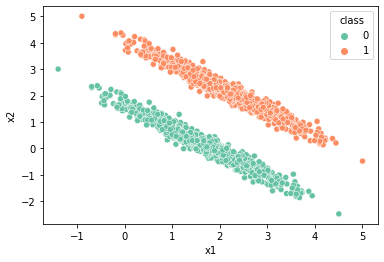

In [34]:
X,y = sklearn.datasets.make_blobs(n_samples=1000, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y
graph = sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2')

In [35]:

instance2explain = {'x1':1.5,'x2':-0.5, 'class':0}
instance2explain = {'x1':0,'x2':1.5, 'class':0}
#instance2explain = {'x1':0,'x2':1, 'class':0}


# X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.05, random_state=0)
# X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=2, random_state=3,
#                                               n_informative=2, n_redundant=0, n_repeated=0, n_clusters_per_class=2,
#                                               n_classes=2)

X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
transformation = [[0.4, -0.3], [0.4, -0.2]]
transformation =[[0.8, -0.8], [0.4, -0.2]]
X = np.dot(X, transformation)
X2 = X.copy()
X2[:,0]+=0.5
X2[:,1]+=2
X=np.concatenate((X,X2))
y= np.concatenate((y,y+1))


Xdf = pd.DataFrame(X, columns=['x1','x2'])
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain
train = pd.concat((train, pd.DataFrame([np.array(list(instance2explain.values()))],columns=instance2explain.keys())), axis=0,ignore_index=True)
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

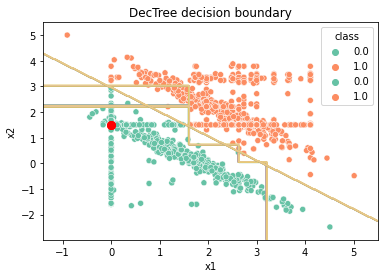

In [36]:
depth = 4
exclf_lore = DecisionTreeClassifier(max_depth=depth)
exclf_lore.fit(Zdf[features], Zdf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

### Explan

In [26]:
from explan import DataGeneration,DataSelection,DataBalancing
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf = pd.DataFrame(neighborhood_data, columns=features)
Ndf[target] = blackbox.predict(Ndf[features])

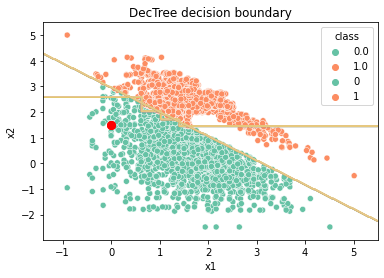

In [27]:
depth = 4
exclf_expl = DecisionTreeClassifier(max_depth=depth)
exclf_expl.fit(Ndf[features], Ndf[target])
    
graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=graph.axes)

decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=graph.axes)

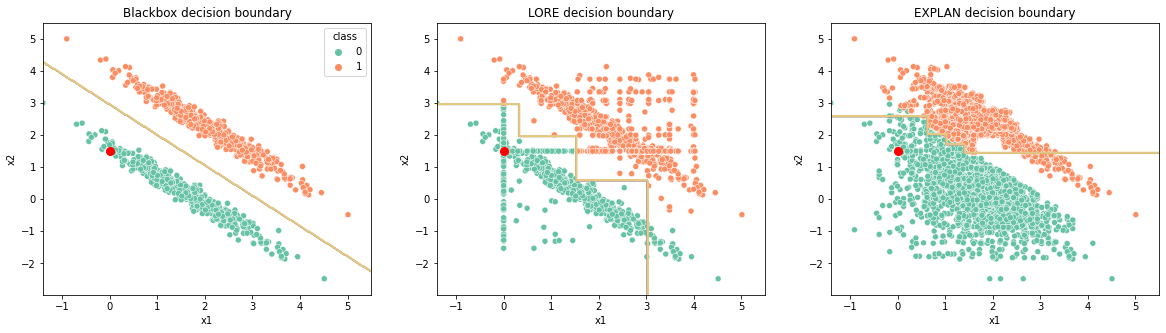

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5),sharex=False,sharey=False)
sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2',ax=axes[0])
decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[0])


sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
sns.scatterplot(data=Zdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[1])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
sns.scatterplot(data=Ndf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2], legend=False)
decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[2])

axes[0].set_title('Blackbox decision boundary')
axes[1].set_title('LORE decision boundary')
axes[2].set_title('EXPLAN decision boundary')

plt.savefig('./pix/degenerated-decbounds.pdf', format='pdf',bbox_inches='tight')

### LUX

In [29]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0,min_samples=50 )
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

In [30]:
Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

<AxesSubplot:xlabel='x1', ylabel='x2'>

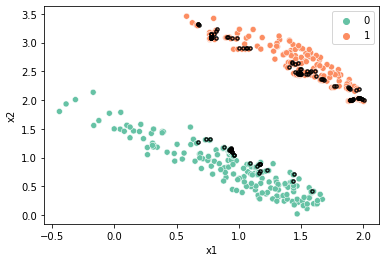

In [34]:
#graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2')
graph = sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2')#,ax=graph.axes)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=graph.axes)

### Lux on more complex example

In [23]:
simple=True
if not simple:
    X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.25, random_state=0)#factor=0.5
    Xdf = pd.DataFrame(X, columns=['x1','x2'])
    Xdf[target] = y
    features = [f for f in Xdf.columns if f not in [target]]
    train, test = train_test_split(Xdf, test_size=0.33, random_state=42)
else:
    X,y = sklearn.datasets.make_blobs(n_samples=500, centers=1, random_state=42)
    transformation = [[0.4, -0.3], [0.4, -0.2]]
    transformation =[[0.8, -0.8], [0.4, -0.2]]
    X = np.dot(X, transformation)
    X2 = X.copy()
    X2[:,0]+=0.5
    X2[:,1]+=2
    X=np.concatenate((X,X2))
    y= np.concatenate((y,y+1))


    Xdf = pd.DataFrame(X, columns=['x1','x2'])
    Xdf['class'] = y

    target = 'class'
    features = [f for f in Xdf.columns if f not in [target]]
    train, test= train_test_split(Xdf, test_size=0.33, random_state=42)


blackbox = GradientBoostingClassifier()#xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')#LogisticRegression()
blackbox.fit(train[features], train[target])

GradientBoostingClassifier()

In [24]:
dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})

Zdf_complex,Z = generate_phantom_data(idx_record2explain=len(train)-1, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=True,
            continuous_function_estimation=True)

In [25]:
i2e = train.iloc[len(train)-1][features].values
dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
# Representative data selection step
representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
# Data balancing step
neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

Ndf_complex = pd.DataFrame(neighborhood_data, columns=features)
Ndf_complex[target] = blackbox.predict(Ndf_complex[features])

In [26]:
lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.2,max_depth=2,  node_size_limit = 2, grow_confidence_threshold = 0 )
X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=True,
                                         representative='centroid')

X_train_sample_noos, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[len(train)-1][features].values],X_importances = None, 
                                         exclude_neighbourhood=False, use_parity=True, 
                                         inverse_sampling=True, class_names=[0,1],density_sampling=False, radius_sampling=True, 
                                         oversampling=False,
                                         representative='centroid')

Zdf_lux = pd.DataFrame(X_train_sample, columns=['x1','x2'])
Zdf_lux[target] = blackbox.predict(Zdf_lux)

Zdf_lux_noos = pd.DataFrame(X_train_sample_noos, columns=['x1','x2'])
Zdf_lux_noos[target] = blackbox.predict(Zdf_lux_noos)


only_gnerated = Zdf_lux[~Zdf_lux[features].apply(tuple,1).isin(Zdf_lux_noos[features].apply(tuple,1))]

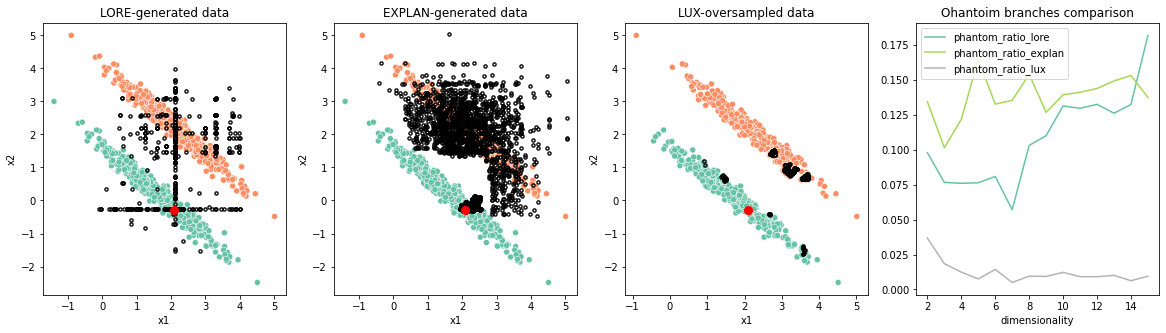

In [29]:
sdf = pd.read_csv('phantoms.csv')
fig, axes = plt.subplots(1, 4, figsize=(20, 5),sharex=False,sharey=False)
#sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class',palette='Set2',ax=axes[0])
#decision_boundary(blackbox,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[0])


sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[0], legend=False)
sns.scatterplot(data=Zdf_complex,x='x1', y='x2',ax=axes[0], legend=False,marker="$\circ$", ec="face", color='black')
#decision_boundary(exclf_lore,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[1])

sns.scatterplot(data=Xdf,x='x1', y='x2', hue='class', palette='Set2',ax=axes[1], legend=False)
sns.scatterplot(data=Ndf_complex,x='x1', y='x2',ax=axes[1],marker="$\circ$", ec="face", color='black', legend=False)
#decision_boundary(exclf_expl,train.iloc[len(train)-1], train[features],train[target],f1='x1',f2='x2', dec_only=True, ax=axes[2])

axes[0].plot(i2e[0], i2e[1], 'or', markersize=8)
axes[1].plot(i2e[0], i2e[1], 'or', markersize=8)
axes[2].plot(i2e[0], i2e[1], 'or', markersize=8)

graph = sns.scatterplot(data=train,x='x1', y='x2', hue='class',palette='Set2',ax=axes[2],legend=False)
sns.scatterplot(data=Zdf_lux,x='x1', y='x2', hue='class', palette='Set2',ax=axes[2],legend=False)
sns.scatterplot(data=only_gnerated,x='x1', y='x2', marker="$\circ$", ec="face", color='black',ax=axes[2],legend=False)
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux']].mean().plot(ax=axes[3], cmap='Set2')



axes[0].set_title('LORE-generated data')
axes[1].set_title('EXPLAN-generated data')
axes[2].set_title('LUX-oversampled data')
axes[3].set_title('Ohantoim branches comparison')


plt.savefig('./pix/lux-oversampling.pdf', format='pdf',bbox_inches='tight')

## Branch utilisation (phantom branches)

In [ ]:
# generate neigh with lore, explan
# fit uid3, use counterfactual code genration on real data to see how it goes
def get_covered(rule, dataset, features, categorical=None):
    if categorical is None:
        categorical = [False]*len(features)
    query = []
    if rule == {}:
        return 0,0
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical))[i] == False else '=='
        query.append(f'{i}{op}'+f'and {i}{op}'.join(v))

    covered = dataset.query(' and '.join(query))
    return covered

def coverage_rules(tree, background_train, background_eval,features):
    rules  = tree.to_dict(reduce=True)

    #filter out rules with class same as not_class
    coever_rules = []
    mingen = None
    numfan = 0
    for rule in rules:
        coever_rules.append(rule)
        #find coverage points from background
        rule['covered'] = len(get_covered(rule['rule'],background_eval, features, None))/len(get_covered(rule['rule'],background_train, features, None))
        #find candidates from background according to counterfactual_representative
        if mingen is None or mingen > rule['covered']:
            mingen=rule['covered']
        if rule['covered'] == 0:
            numfan+=1
    return coever_rules,mingen,numfan,numfan/len(rules)

summary=[]
for f in range(2,20):
    for _ in range(1,100):
        if f > 4:
            f2=int(f/2)
            f3=int(f/3)
            f1=f
        else:
            f1=f2=2
            f3=1
            
        try:
            X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=f1, #random_state=3,
                                                           n_informative=f2, n_redundant=0, n_repeated=0, n_clusters_per_class=f3,
                                                           n_classes=3)
            cols = [f'f_{i}' for i in range(0,X.shape[1])]
            Xdf = pd.DataFrame(X, columns=cols)
            Xdf['class'] = y

            target = 'class'
            features = [f for f in Xdf.columns if f not in [target]]
            train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

            blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
            blackbox.fit(train[features],train[target])

            #train.loc[len(train)] = instance2explain
            idx = random.randint(0, len(train))
            dataset = prepare_ds(train, name = 'dataset', class_name='class', discrete=[], label_encoder={})


            Zdf,Z = generate_phantom_data(idx_record2explain=idx, X2E=train[features].values, dataset=dataset, blackbox=blackbox,
                        ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
                        discrete_use_probabilities=True,
                        continuous_function_estimation=True)



            i2e = train.iloc[idx][features].values
            dense_samples = DataGeneration(i2e, blackbox, dataset, 3000)
            # Representative data selection step
            representative_samples = DataSelection(i2e, blackbox, dense_samples, 250)
            # Data balancing step
            neighborhood_data = DataBalancing(blackbox, representative_samples, dataset)

            Ndf = pd.DataFrame(neighborhood_data, columns=features)
            Ndf[target] = blackbox.predict(Ndf[features])


            lux = LUX(predict_proba = blackbox.predict_proba, neighborhood_size=0.3,max_depth=2,  node_size_limit = 2, 
                      grow_confidence_threshold = 0, min_samples=10 )
            X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[train.iloc[idx][features].values],X_importances = None, 
                                                 exclude_neighbourhood=False, use_parity=True, 
                                                 inverse_sampling=True, class_names=[0,1],density_sampling=True, radius_sampling=False, 
                                                 oversampling=True,
                                                 representative='centroid')

            #LORE
            data = Data.parse_dataframe(Zdf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lore = len(uid3.tree.to_dict())
            crgen,mg,numfan,prop = coverage_rules(uid3.tree, Zdf, train,features=features)

            #EXPLAN
            data = Data.parse_dataframe(Ndf)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_explan = len(uid3.tree.to_dict())
            crgen_ep,mg_ep,numfan_ep,prop_ep = coverage_rules(uid3.tree, Ndf, train,features=features)

            ##LUX
            X_train_sample_c = X_train_sample.copy()
            X_train_sample_c[target] = blackbox.predict(X_train_sample_c)
            data = Data.parse_dataframe(X_train_sample_c)
            uid3 = UId3(max_depth=10,node_size_limit=2)
            uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=-1)
            rnum_lux = len(uid3.tree.to_dict())
            crgreal,mr,numfanr,propr = coverage_rules(uid3.tree, X_train_sample_c, train,features=features)
            print(f'Num of features {f} Minimal coverage generated {mg}, minimal coverage real {mr}, proportion of phantom: {numfan}')
            summary.append([f,mg,mg_ep,mr,numfan,numfan_ep,numfanr,prop,prop_ep,propr,rnum_lore, rnum_explan, rnum_lux])
        except:
            pass
        
    

In [ ]:
sdf = pd.DataFrame(summary, columns=['dimensionality','min_cov_lore','min_cov_explan','min_cov_lux','phantom_no_lore','phantom_no_explan',
                                     'phantom_no_lux','phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux',
                                     'rules_lore','rules_explan','rules_lux'])
#sdf.to_csv('phantoms.csv',index=False)

In [ ]:
sdf = pd.read_csv('phantoms.csv')

In [ ]:
sdf.groupby('dimensionality')[['phantom_no_lore','phantom_no_explan','phantom_no_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[['phantom_ratio_lore','phantom_ratio_explan','phantom_ratio_lux']].mean().plot()

In [ ]:
sdf.groupby('dimensionality')[[ 'rules_lore','rules_explan','rules_lux']].mean().plot()

## Example of oblique necessity (lineary decbound in DT is counterintuitive fro experts) -- DT DOES NOT ALWAYS CAPTURES WHAT MODEL TRIES TO CAPTURE

## Need for visualization of explanations throuhg the lenses of DS (explanation should be backed by data distribution, otherwise it is missing important informaiton)

In [ ]:
sdf['dimensionality'].max()

## Tradeoff between locla/global by selecting the fraction

# Stability among same instance

In [ ]:
f=8
X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=f, random_state=3,
                                                       n_informative=int(f/2), n_redundant=0, n_repeated=0, n_clusters_per_class=int(f/3),
                                                       n_classes=2)
cols = [f'f_{i}' for i in range(0,X.shape[1])]
Xdf = pd.DataFrame(X, columns=cols)
Xdf['class'] = y

target = 'class'
features = [f for f in Xdf.columns if f not in [target]]
train, test= train_test_split(Xdf, test_size=0.33, random_state=42)

blackbox = SVC(kernel='linear',probability=True)#GradientBoostingClassifier()
blackbox.fit(train[features],train[target])

#train.loc[len(train)] = instance2explain


In [ ]:
idx = 10
i2e = train.iloc[idx][features].values
dataset = prepare_ds(train.copy(), name = 'dataset', class_name='class', discrete=[], label_encoder={})

In [ ]:

rules_temp=[]
stab_stats=[]
stability_data=[]
# EXPLAN hyper-parameters
N_samples = 3000#n_neighbors
tau = 250#int(n_neighbors)/len(np.unique(df[target])

pos_label = blackbox.predict(np.array(i2e).reshape(1,-1))[0]
for _ in range(0,100):
    # Explaining instance x using EXPLAN
    exp_EXPLAN, info_EXPLAN = explan.Explainer(i2e,
                                               blackbox,
                                               dataset,
                                               N_samples=N_samples,
                                               tau=tau,depth=depth)
    rule_EXPLAN = {} 
    for i,v in  exp_EXPLAN[1].items():
        rule_EXPLAN[i] = [v]

    rule_EXPLAN = split_rule_conditions(rule_EXPLAN)
    #EXPLAN expl e = {'f_2': '0.426178< f_2 <=1.226002', 'f_4': '<=0.608496', 'f_7': '>-0.403450'}

    cov_EXPLAN, acc_EXPLAN, prec_EXPLAN, rec_EXPLAN, f1_EXPLAN = coverage_precision(rule_EXPLAN, test, features, 
                                                                                    [False]*len(features), exp_EXPLAN[0][dataset['class_name']], 
                                                                                    class_label='class')

    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%% LORE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
    exp_LORE, info_LORE = lore.explain(0, X_explain,
                                       dataset, blackbox,
                                       ng_function=genetic_neighborhood,
                                       discrete_use_probabilities=True,
                                       continuous_function_estimation=False,
                                       returns_infos=True, path='./EXPLAN/yadt/',
                                       sep=';', log=True, depth=depth)

    rule_LORE = {} 
    for i,v in  exp_LORE[0][1].items():
        rule_LORE[i] = [v]

    rule_LORE = split_rule_conditions(rule_LORE)

    cov_LORE, acc_LORE, prec_LORE, rec_LORE, f1_LORE = coverage_precision(rule_LORE, test, features, [False]*len(features), 
                                                                          exp_LORE[0][0][dataset['class_name']], class_label='class')
   
    
    ############################ ANCHOR ######################################
    X_explain = np.concatenate((np.array(i2e).reshape(1,-1), dataset['X']))
    anchor_explainer = fit_anchor(dataset, train[features].values, train[features].values, train[target].values, train[target].values, X_explain)
    exp_Anchor = anchor_explainer.explain_instance(X_explain[0].reshape(1, -1),
                                                                blackbox.predict, threshold=np.max([0.5]+[f for f in [prec_LORE,prec_EXPLAN] if f is not np.nan]))

    anch_depth = min(depth-1,len(exp_Anchor.exp_map['feature'])-1)
    ats_anchor=['f_'+str(f) for f in exp_Anchor.exp_map['feature'][:anch_depth+1]]



    #fit_partial = np.where(np.all(X_explain[:, exp_Anchor.features(anch_depth)] == X_explain[0][exp_Anchor.features(anch_depth)], axis=1))[0]
    #prec_anchor =  (np.mean(clf.predict(X_explain[fit_partial]) == clf.predict(X_explain[0].reshape(1, -1))))
    #cov_anchor = exp_Anchor.exp_map['coverage'][anch_depth]
    #print('Partial anchor test coverage: %.2f' % (fit_partial.shape[0] / float(X_explain.shape[0])))

    rule_Anchor_full = anchor2arule(exp_Anchor)
    rule_Anchor={}
    for i,v in rule_Anchor_full.items():
        if i in ats_anchor[:anch_depth+1]:
            rule_Anchor[i]=[v]

    dfXExplain = build_df2explain(blackbox, X_explain, dataset)
    rule_Anchor = split_rule_conditions(rule_Anchor)

    cov_anchor, acc_anchor, prec_anchor, rec_anchor, f1_anchor = coverage_precision(rule_Anchor, test, features, 
                                                                                    [False]*len(features), pos_label, class_label='class')
        
    
   
    
    ##########################################LUX
    
    start_time = time.time()
    lux = LUX(classifier = clf,predict_proba = clf.predict_proba, 
              neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
    X_train_sample, _ = lux.create_sample_bb(train[features], clf.predict(train[features]),[explain_instance], categorical=categorical_indicator,
                                                  X_importances = None, exclude_neighbourhood=False, class_names=np.unique(y),
                                                  use_parity=True, inverse_sampling=True, radius_sampling=False,oversampling=True,
                                                 representative='centroid',density_sampling=True,n_jobs=-1)
    lux.attributes_names=X_train_sample.columns
    # lux.fit(train[features], train[target], 
    #         X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
    #         instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
    #         use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, categorical=categorical_indicator,n_jobs=-1 )

    ## To make it faster, not repeat neighbourhood selection step every time:
    y_train_sample = lux.predict_proba(X_train_sample)
    #limit features here
    uarff=LUX.generate_uarff(X_train_sample,y_train_sample, X_importances=None,categorical=categorical_indicator,class_names=np.unique(y))
    udata = Data.parse_uarff_from_string(uarff)
    print(f'In fact using: {len(X_train_sample)/len(train)} samples from train set wiuth class balance: {sum(np.argmax(y_train_sample,axis=1))/len(y_train_sample)}')
    lux.uid3 = UId3(max_depth=lux.max_depth, node_size_limit=lux.node_size_limit, grow_confidence_threshold=lux.grow_confidence_threshold,min_impurity_decrease=lux.min_impurity_decrease)
    if lux.classifier is not None:
        lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, classifier=lux.classifier, discount_importance=True,
                                depth=0,beta=1,n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
    else:
        lux.tree = lux.uid3.fit(udata, entropyEvaluator=uncertain_entropy_evaluator, depth=0,discount_importance=True,beta=1,
                                n_jobs=n_jobs,prune=True,oblique=oblique,imp=rsv)
        
    
    justification_dict = lux.justify(explain_instance, to_dict=True)[0][0]
    rule_lux_shap = justification_dict['rule']
        
    rules_temp.append([np.array(i2e).reshape(1,-1),blackbox.predict(np.array(i2e).reshape(1,-1))[0],rule_EXPLAN, rule_LORE, rule_Anchor,rule_lux_shap])
    
    
results_rules = pd.DataFrame(rules_temp, columns=['explain_instance','true_class','rule_EXPLAN', 'rule_LORE','rule_ANCHOR','rule_LUX'])
stab_stats = [stability_stats(results_rules, rid, train, features, [False]*len(features)) for rid in ['rule_EXPLAN','rule_LORE']]
stability_data.append(['tmp','tmp']+list(np.concatenate(stab_stats)))
## save results       

#TODO: coverage, prec/rec/f1, variance as entropy of counts of appearence of variables in explanations

In [ ]:
#stability_data.to_csv('stability.csv',ignore_index = False)

In [ ]:
print('dsf')

# Evaluation

In [1]:
from scipy.stats import friedmanchisquare,rankdata,f
import scikit_posthocs as sp
import numpy as np
import Orange 
import pandas as pd

In [2]:
def to_latex(aggregated, aggregated_std, index_name='', caption='',label=''):
    aggregated=aggregated.replace('_','\_')
    aggregated_std=aggregated_std.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+'&'.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i,row in aggregated.iterrows():
        row_std = aggregated_std.loc[i]
        rowstring = []
        for r,r_std in zip(row,row_std):
            rowstring.append("{:0.2f}".format(r)+' $\pm$ '+"{:0.2f}".format(r_std))
        print(str(i)+' & '+' & '.join(rowstring)+'\\\\ \hline')
    print('\\end{tabularx}\n\\end{table}')

In [3]:
def to_latex_nostd(aggregated, index_name='', caption='',label=''):
    aggregated=aggregated.replace('_','\_')
    print('\\begin{table}')
    print('\\caption{'+caption+'}')
    print('\\label{'+label+'}')
    print('\\begin{tabularx}{\\textwidth}{|X|'+'|'.join(['X']*len(aggregated.columns))+'|}')
    print('\\hline')
    print(index_name+' & '+'&'.join(aggregated.columns))
    print('\\\\ \\hline \\hline')
    for i,row in aggregated.iterrows():
        rowstring = []
        for r in row:
            rowstring.append("{:0.2f}".format(r))
        print(str(i)+' & '+' & '.join(rowstring)+'\\\\ \hline')
    print('\\end{tabularx}\n\\end{table}')

## Fidelity

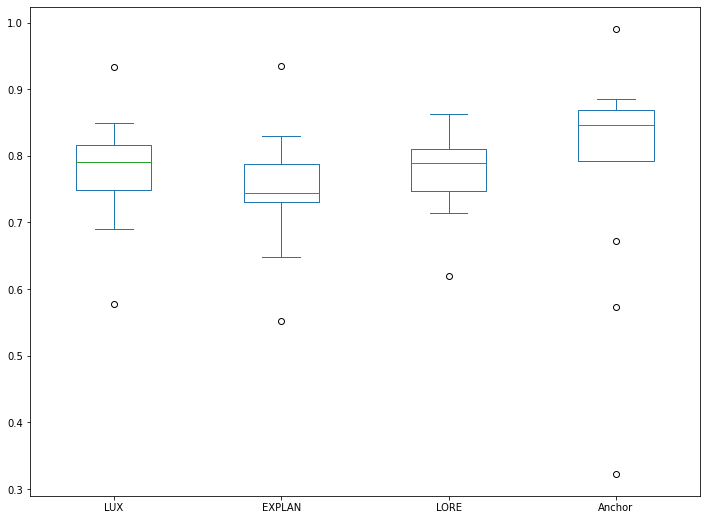

In [79]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv('./results/realx100_deep_prune_oblique_dfneigh_os/synthx100_local_fid.csv').fillna(0).groupby('dataset')[['f1_shap','f1_EXPLAN','f1_LORE','f1_anchor']].mean()
aggregated.columns=['LUX','EXPLAN','LORE','Anchor']
aggregated.plot(kind='box', ax=ax)
aggregated_std = pd.read_csv('./results/realx100_deep_prune_oblique_dfneigh_os/synthx100_local_fid.csv').fillna(0).groupby('dataset')[['f1_shap','f1_EXPLAN','f1_LORE','f1_anchor']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE','Anchor']


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
cancer & 0.93 $\pm$ 0.12 & 0.93 $\pm$ 0.16 & 0.79 $\pm$ 0.26 & 0.99 $\pm$ 0.03\\ \hline
data_MagicTelescope & 0.80 $\pm$ 0.18 & 0.74 $\pm$ 0.18 & 0.82 $\pm$ 0.14 & 0.85 $\pm$ 0.15\\ \hline
data_bank-marketing & 0.77 $\pm$ 0.15 & 0.77 $\pm$ 0.15 & 0.75 $\pm$ 0.18 & 0.87 $\pm$ 0.06\\ \hline
data_california & 0.79 $\pm$ 0.19 & 0.81 $\pm$ 0.16 & 0.83 $\pm$ 0.13 & 0.87 $\pm$ 0.10\\ \hline
data_credit & 0.75 $\pm$ 0.09 & 0.74 $\pm$ 0.11 & 0.79 $\pm$ 0.09 & 0.67 $\pm$ 0.34\\ \hline
data_electricity & 0.75 $\pm$ 0.20 & 0.73 $\pm$ 0.16 & 0.78 $\pm$ 0.10 & 0.82 $\pm$ 0.14\\ \hline
data_eye_movements & 0.58 $\pm$ 0.18 & 0.55 $\pm$ 0.17 & 0.62 $\pm$ 0.19 & 0.57 $\pm$ 0.07\\ \hline
data_house_16H & 0.84 $\pm$ 0.17 & 0.79 $\pm$ 0.15 & 0.86 $\pm$ 0.10 & 0.87 $\pm$ 0.25\\ \hline
data_jannis & 0.69 $\pm$ 0.22 & 0.65 $\pm$ 0.17 & 0.71 $\pm$ 0.17 & 0.79 $\pm$ 0.13\\ \hline


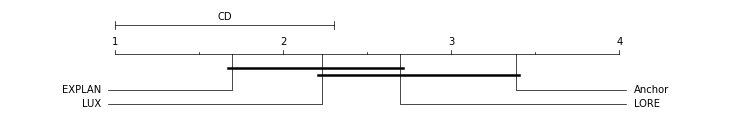

In [59]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_fidelity.eps')

## Simplicity

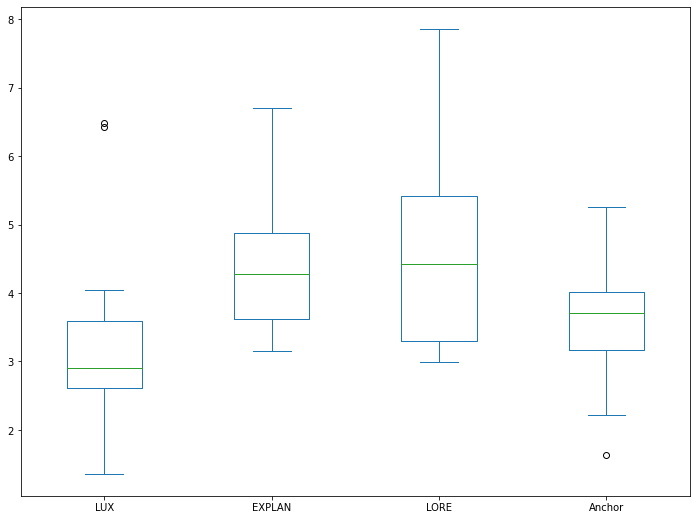

In [71]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv('./results/realx100_deep_prune_oblique_dfneigh_os/synthx100_rulelen.csv').dropna().groupby('dataset')[['shap_lux_elen','explan_elen','lore_elen','anchor_elen']].mean()
aggregated.columns=['LUX','EXPLAN','LORE','Anchor']
aggregated.plot(kind='box', ax=ax)
aggregated_std = pd.read_csv('./results/realx100_deep_prune_oblique_dfneigh_os/synthx100_rulelen.csv').dropna().groupby('dataset')[['shap_lux_elen','explan_elen','lore_elen','anchor_elen']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE','Anchor']


In [72]:
 to_latex(aggregated, aggregated_std, index_name='dataset')

\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
cancer & 1.36 $\pm$ 0.50 & 6.31 $\pm$ 2.82 & 5.41 $\pm$ 2.42 & 2.36 $\pm$ 0.53\\ \hline
data_MagicTelescope & 3.59 $\pm$ 1.22 & 4.17 $\pm$ 1.19 & 4.04 $\pm$ 1.71 & 4.58 $\pm$ 3.52\\ \hline
data_bank-marketing & 2.75 $\pm$ 1.21 & 3.34 $\pm$ 1.63 & 2.99 $\pm$ 1.48 & 3.78 $\pm$ 2.78\\ \hline
data_california & 2.99 $\pm$ 1.28 & 3.62 $\pm$ 0.97 & 3.31 $\pm$ 1.06 & 3.21 $\pm$ 2.00\\ \hline
data_credit & 2.76 $\pm$ 1.45 & 3.73 $\pm$ 1.76 & 4.42 $\pm$ 1.76 & 4.01 $\pm$ 2.02\\ \hline
data_electricity & 2.62 $\pm$ 1.40 & 3.25 $\pm$ 1.51 & 3.20 $\pm$ 1.62 & 3.71 $\pm$ 2.81\\ \hline
data_eye_movements & 6.42 $\pm$ 2.17 & 5.84 $\pm$ 2.39 & 7.12 $\pm$ 1.87 & 1.64 $\pm$ 0.71\\ \hline
data_house_16H & 4.04 $\pm$ 1.15 & 4.88 $\pm$ 1.82 & 5.25 $\pm$ 1.62 & 3.16 $\pm$ 1.13\\ \hline
data_jannis & 6.49 $\pm$ 2.60 & 6.70 $\pm$ 2.91 & 7.86 $\pm$ 2.61 & 2.22 $\pm$ 0.86\\ \hline


In [73]:
result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'],aggregated['Anchor'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

0.001282931739769337

In [74]:
ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')

Reject null-hypothesis 2.86626555094018 < 15.738461538461564
Number of freedom degrees: 3 x 36


In [75]:

nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

,LUX,EXPLAN,LORE,Anchor
LUX,1.000000,0.004618,0.002683,0.048246
EXPLAN,0.004618,1.000000,0.900000,0.858810
LORE,0.002683,0.900000,1.000000,0.773540
Anchor,0.048246,0.858810,0.773540,1.000000


In [76]:
avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

array([1.30769231, 3.        , 3.07692308, 2.61538462])

cd=1.300879920848843


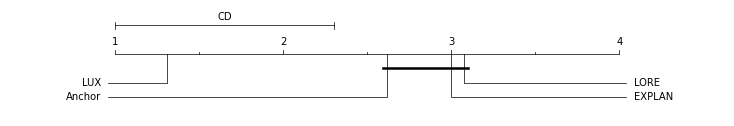

In [77]:
cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_simplicity.eps')

## Counterfactuals

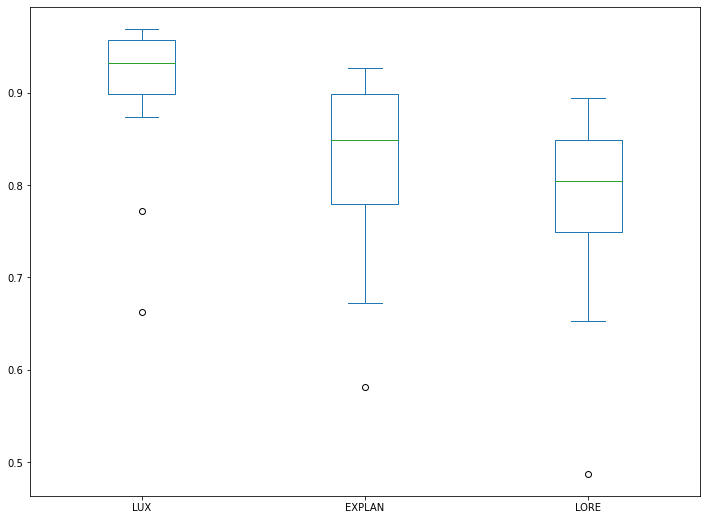

In [67]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv('./results/realx100_deep_prune_oblique_dfneigh_os/synthx100_scores.csv').fillna(0).groupby('dataset')[['f1_score_shap','f1_score_explan','f1_score_lore']].mean()
aggregated.columns=['LUX','EXPLAN','LORE']
aggregated.plot(kind='box', ax=ax)
aggregated_std = pd.read_csv('./results/realx100_deep_prune_oblique_dfneigh_os/synthx100_scores.csv').fillna(0).groupby('dataset')[['f1_score_shap','f1_score_explan','f1_score_lore']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE']


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|}
\hline
dataset & LUX&EXPLAN&LORE
\\ \hline \hline
cancer & 0.96 $\pm$ 0.07 & 0.92 $\pm$ 0.11 & 0.89 $\pm$ 0.24\\ \hline
data_MagicTelescope & 0.90 $\pm$ 0.08 & 0.76 $\pm$ 0.15 & 0.75 $\pm$ 0.16\\ \hline
data_bank-marketing & 0.94 $\pm$ 0.04 & 0.90 $\pm$ 0.10 & 0.85 $\pm$ 0.16\\ \hline
data_california & 0.93 $\pm$ 0.03 & 0.85 $\pm$ 0.10 & 0.79 $\pm$ 0.16\\ \hline
data_credit & 0.96 $\pm$ 0.03 & 0.93 $\pm$ 0.09 & 0.89 $\pm$ 0.11\\ \hline
data_electricity & 0.93 $\pm$ 0.11 & 0.86 $\pm$ 0.13 & 0.85 $\pm$ 0.15\\ \hline
data_eye_movements & 0.66 $\pm$ 0.06 & 0.58 $\pm$ 0.10 & 0.49 $\pm$ 0.13\\ \hline
data_house_16H & 0.90 $\pm$ 0.05 & 0.82 $\pm$ 0.12 & 0.79 $\pm$ 0.13\\ \hline
data_jannis & 0.77 $\pm$ 0.11 & 0.67 $\pm$ 0.15 & 0.65 $\pm$ 0.16\\ \hline
data_kdd_ipums_la_97-small & 0.96 $\pm$ 0.04 & 0.89 $\pm$ 0.16 & 0.85 $\pm$ 0.26\\ \hline
data_phoneme & 0.95 $\pm$ 0.07 & 0.90 $\pm$ 0.11 & 0.89 $\pm$ 0.14\\ \hline
data_

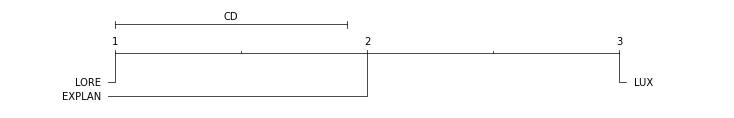

In [68]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_counterfactuals.eps')

## Coverage

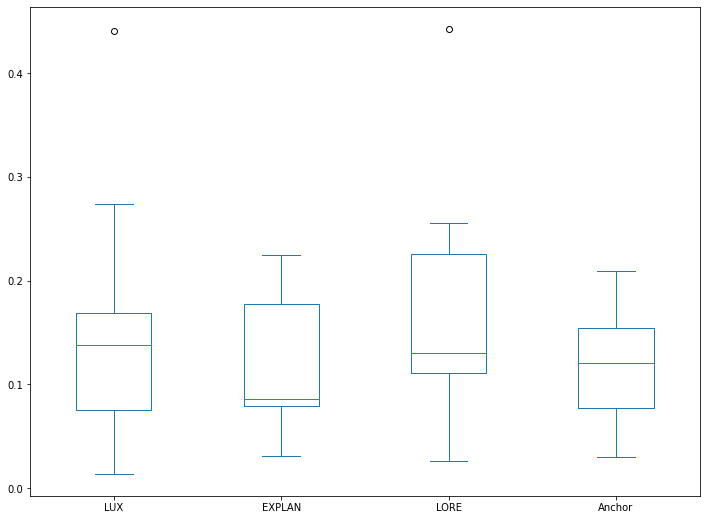

In [69]:

fig, ax = plt.subplots(figsize=(12,9))
aggregated = pd.read_csv('./results/realx100_deep_prune_oblique_dfneigh_os/synthx100_rulecov.csv').fillna(0).groupby('dataset')[['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor']].mean()
aggregated.columns=['LUX','EXPLAN','LORE', 'Anchor']
aggregated.plot(kind='box', ax=ax)
aggregated_std = pd.read_csv('./results/realx100_deep_prune_oblique_dfneigh_os/synthx100_rulecov.csv').fillna(0).groupby('dataset')[['cov_shap','cov_EXPLAN','cov_LORE', 'cov_anchor']].std()
aggregated_std.columns=['LUX','EXPLAN','LORE','Anchor']


\begin{table}
\caption{}
\label{}
\begin{tabularx}{\textwidth}{|X|X|X|X|X|}
\hline
dataset & LUX&EXPLAN&LORE&Anchor
\\ \hline \hline
cancer & 0.44 $\pm$ 0.16 & 0.19 $\pm$ 0.17 & 0.44 $\pm$ 0.23 & 0.17 $\pm$ 0.07\\ \hline
data_MagicTelescope & 0.07 $\pm$ 0.08 & 0.06 $\pm$ 0.06 & 0.13 $\pm$ 0.13 & 0.09 $\pm$ 0.09\\ \hline
data_bank-marketing & 0.13 $\pm$ 0.12 & 0.18 $\pm$ 0.14 & 0.25 $\pm$ 0.16 & 0.13 $\pm$ 0.09\\ \hline
data_california & 0.14 $\pm$ 0.21 & 0.08 $\pm$ 0.09 & 0.13 $\pm$ 0.09 & 0.07 $\pm$ 0.05\\ \hline
data_credit & 0.27 $\pm$ 0.21 & 0.21 $\pm$ 0.19 & 0.23 $\pm$ 0.16 & 0.15 $\pm$ 0.12\\ \hline
data_electricity & 0.15 $\pm$ 0.17 & 0.14 $\pm$ 0.12 & 0.19 $\pm$ 0.15 & 0.12 $\pm$ 0.10\\ \hline
data_eye_movements & 0.01 $\pm$ 0.02 & 0.05 $\pm$ 0.08 & 0.03 $\pm$ 0.05 & 0.21 $\pm$ 0.12\\ \hline
data_house_16H & 0.08 $\pm$ 0.08 & 0.08 $\pm$ 0.07 & 0.11 $\pm$ 0.10 & 0.08 $\pm$ 0.08\\ \hline
data_jannis & 0.02 $\pm$ 0.03 & 0.03 $\pm$ 0.03 & 0.05 $\pm$ 0.06 & 0.15 $\pm$ 0.12\\ \hline


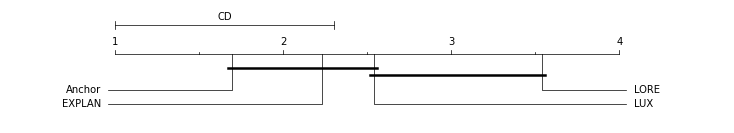

In [70]:
print(to_latex(aggregated, aggregated_std, index_name='dataset'))

result = friedmanchisquare(aggregated['LUX'],aggregated['EXPLAN'],aggregated['LORE'])#, aggregated['Isolation forest'], aggregated['K-D tree query'], aggregated['Random selection'])
result[0]
result[1]

ppf=f.ppf(q=1-.05, dfn=aggregated.shape[1]-1, dfd=(aggregated.shape[0]-1)*(aggregated.shape[1]-1))
if ppf < result[0]:
    print(f'Reject null-hypothesis {ppf} < {result[0]}')
else:
    print('Not reject null-hypothessis')
print(f'Number of freedom degrees: {aggregated.shape[1]-1} x {(aggregated.shape[0]-1)*(aggregated.shape[1]-1)}')


nemfried = sp.posthoc_nemenyi_friedman(aggregated)
nemfried

avranks=rankdata(aggregated, axis=1)
avranks = np.mean(avranks, axis=0)
avranks

cd = Orange.evaluation.compute_CD(avranks, aggregated.shape[0],alpha="0.05", test="nemenyi")
print(f'cd={cd}')
Orange.evaluation.graph_ranks(avranks, names=list(aggregated.columns), cd=cd, width=10, textspace=1.5
                              ,filename='./imgs/nemenyi_coverage.eps')